In [54]:
#libaries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory


In [48]:
#Creating/Defining Data Loader

def create_data_loader(train_dir, test_dir, valid_dir, image_size=(299, 299), batch_size=32, limit=None):
    train_ds = image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )
    
    test_ds = image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    valid_ds = image_dataset_from_directory(
        valid_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )
    
    if limit:
        train_ds = train_ds.take(limit)
        test_ds = test_ds.take(limit)
        valid_ds = valid_ds.take(limit)

    return train_ds, test_ds, valid_ds


In [49]:
#Creating/Defining Transfer Model & the architecture of the model

def create_transfer_model(input_shape, num_classes):
    backbone = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = keras.applications.inception_v3.preprocess_input(inputs)
    x = backbone(x, training=False) 
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs, name="transfer_model")


In [51]:
#Compiling model, creating checkpoints, and running the mode on our dataset

train_dir = 'Data/Train'
test_dir = 'Data/Test'
valid_dir = 'Data/Valid'

train_ds, test_ds, valid_ds = create_data_loader(train_dir, test_dir, valid_dir, limit=None)

input_shape = (299, 299, 3) 
num_classes = 4

model = create_transfer_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("inceptionv3_model_checkpoint.keras", save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[checkpoint]
)

model.load_weights("inceptionv3_model_checkpoint.keras")
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy)


Found 494 files belonging to 4 classes.
Found 283 files belonging to 4 classes.
Found 70 files belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3136 - loss: 1.5627 - val_accuracy: 0.3571 - val_loss: 1.4125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4193 - loss: 1.2357 - val_accuracy: 0.3429 - val_loss: 1.2374
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4517 - loss: 1.1123 - val_accuracy: 0.4286 - val_loss: 1.1260
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5274 - loss: 1.0280 - val_accuracy: 0.5143 - val_loss: 1.0346
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6117 - loss: 0.9346 - val_accuracy: 0.4571 - val_loss: 1.1543
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5928 - loss: 0.9294 - val_accuracy: 0.5571 - val_loss: 0.9586
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6297 - los

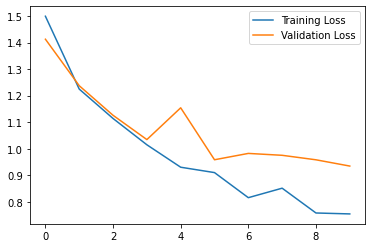

In [52]:
#Roc Curve for loss & Val Loss

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

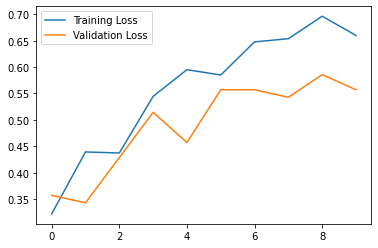

In [53]:
#ROC Curve for accuracy & Val Accuracy

plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Loss")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Loss")
plt.legend()